In [1]:
#%% load required packages

import os
import sys
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
from monai.networks.nets import Regressor
from monai.networks.nets import ResNet
import pandas as pd

In [16]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("./Metadata/IXI_cleaned.csv")
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = df['filepath']

# ages of subjects
ages = np.array(
df['AGE']
)
    
training_images_list= list(images[:480])
test_images_list= list(images[-30:])
training_ages_list= list(ages[:480])
test_ages_list= list(ages[-30:])
# Define transforms
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128,128,128)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128,128,128))])


print("validation data loader")
# create a validation data loader
val_ds = ImageDataset(image_files=training_images_list, labels=training_ages_list, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=2, pin_memory=pin_memory)

print("creating data loader")
# create a training data loader
train_ds = ImageDataset(image_files=test_images_list, labels=test_ages_list, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=pin_memory)



# Define parameters
block_type = "bottleneck"  # or "basic"
layers = [3, 4, 6, 3]  # Example for ResNet-50
block_inplanes = [64, 128, 256, 512]  # Standard ResNet feature sizes
spatial_dims = 3  # 3D images
n_input_channels = 1  # MRI is grayscale (single-channel)
conv1_t_size = 7
conv1_t_stride = 2
num_classes = 1  # Example: Binary classification

# Instantiate ResNet for MRI images
model = ResNet(
    block=block_type,
    layers=layers,
    block_inplanes=block_inplanes,
    spatial_dims=spatial_dims,
    n_input_channels=n_input_channels,  # Set to 1 for MRI
    conv1_t_size=conv1_t_size,
    conv1_t_stride=conv1_t_stride,
    num_classes=num_classes
)
# model = Regressor(in_shape=[1, 128,128,128], out_shape=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2))


validation data loader
creating data loader


In [ ]:

if torch.cuda.is_available():
    model.cuda()
# It is important that we use nn.MSELoss for regression.
loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
val_loss_values = []
writer = SummaryWriter()
max_epochs = 20

lowest_mse= sys.float_info.max
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        all_labels = []
        all_val_outputs = []
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            all_labels.extend(val_labels.cpu().detach().numpy())
            with torch.no_grad():
                val_outputs = model(val_images)
                flattened_val_outputs = [val for sublist in val_outputs.cpu().detach().numpy() for val in sublist]
                all_val_outputs.extend(flattened_val_outputs)

        mse = np.absolute(np.subtract(all_labels, all_val_outputs)).mean()
        val_loss_values.append(mse)

        if mse < lowest_mse:
            lowest_mse = mse
            lowest_mse_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current MAE: {mse:.4f} ")
        print(f"Best MAE: {lowest_mse:.4f} at epoch {lowest_mse_epoch}")
        writer.add_scalar("val_mae", mse, epoch + 1)

print(f"Training completed, lowest_mae: {lowest_mse:.4f} at epoch: {lowest_mse_epoch}")
writer.close()


# %%


----------
epoch 1/20


c:\Users\ruina\anaconda3\envs\torch\Lib\site-packages\torch\_tensor.py:1648: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


1/3, train_loss: 3843.5923
2/3, train_loss: 1824.7650
3/3, train_loss: 2109.5896


c:\Users\ruina\anaconda3\envs\torch\Lib\site-packages\torch\_tensor.py:1648: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


4/3, train_loss: 2422.0183
epoch 1 average loss: 2549.9913
----------
epoch 2/20
1/3, train_loss: 2255.4297
2/3, train_loss: 1981.4802
3/3, train_loss: 2674.0156
4/3, train_loss: 2377.2507
epoch 2 average loss: 2322.0441


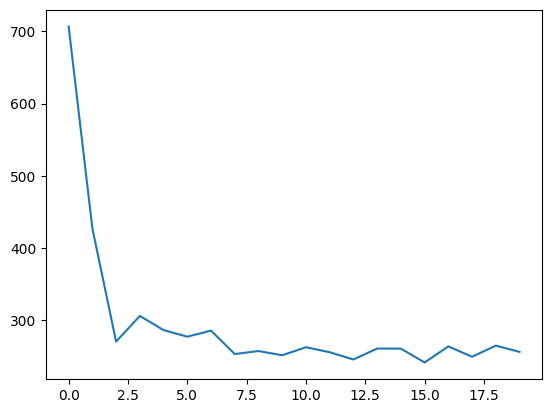

In [19]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss_values)



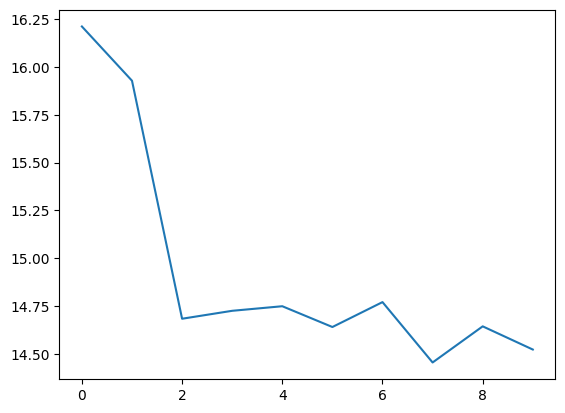

In [20]:
plt.plot(val_loss_values)